In [1]:
import os
import io
import re
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt

from improutils import *

from natsort import natsorted
from skimage import feature, color, transform

from pypylon import pylon 
from pypylon_opencv_viewer import BaslerOpenCVViewer

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import ipywidgets as widgets
from IPython.display import display

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [2]:
def create_slider(min, max, description):
    return widgets.IntRangeSlider( min=min, max=max, step=1,value=[min,max], 
                                   description=description.ljust(30,'\xa0'), 
                                   continuous_update=False, 
                                   orientation='horizontal',
                                   style=dict(description_width='initial'),
                                   layout=widgets.Layout(width='auto', grid_area='header'),
                                  )

In [3]:
# Functions for conversion within different types of coordinates
def convert_pt_to_homogenous(pt):
    """
    Converts the input point from inhomogeneous coordinates to homogeneous ones.

    Parameters
    ----------
    pt : ndarray
        Input point in inhomogeneous coordinates.

    Returns
    -------
    _ : ndarray
        Input point in homogeneous coordinates.
    """
    return np.append(pt, np.array(1))

def convert_pt_from_homogenous(pt):
    """
    Convert input point in homogeneous coordinates to inhomogeneous.

    Parameters
    ----------
    pt : ndarray
        Input point in homogeneous coordinates.

    Returns
    -------
    _ : tuple
        Input point in inhomogeneous coordinates.
    """
    return tuple([elem / pt[-1] for elem in pt[:-1]])

def convert_pts_to_homogenous(pts):
    """
    Convert input points in inhomogeneous coordinates to homogeneous.

    :param pt: ndarray
        Input points in inhomogeneous coordinates.
    :return: ndarray
        Input points in homogeneous coordinates.
    """
    return np.array([convert_pt_to_homogenous(pt) for pt in pts])

def convert_pts_from_homogenous(pts):
    """
    Convert input points in homogeneous coordinates to inhomogeneous.

    :param pt: ndarray
        Input points in homogeneous coordinates.
    :return: ndarray
        Input points in inhomogeneous coordinates.
    """
    return np.array([convert_pt_from_homogenous(pt) for pt in pts])

def _calc_alfa_metric_factor(ref_measurements, vanish_line, vert_vanish_point):
    """
    Calculates alfa metric factor using multiple reference measurements via minimization ||As|| = 0. This is done by SVD.
        In depth overview can be found in https://www.robots.ox.ac.uk/~vgg/publications/1999/Criminisi99b/criminisi99b.pdf - PDF page 104.

    :param ref_measurements: list
        Each measurement is in (t_ref, b_ref, height) format. ``Image coordinates are in inhomogeneous format.
    :param vanish_line: ndarray
        Homogenous coordinates of vanishing line.
    :param vert_vanish_point: ndarray
        Homogenous coordinates of vanishing point in reference direction.
    :return: float
        Scalar value of alfa metric factor calculated by SVD.
    """
    matrix_A = np.empty((len(ref_measurements), 2), dtype='float64')

    for i, (t_ref, b_ref, h_ref) in enumerate(ref_measurements):
        t_ref = convert_pt_to_homogenous(t_ref)
        b_ref = convert_pt_to_homogenous(b_ref)
        beta = np.linalg.norm(np.cross(b_ref, t_ref))
        ro = np.dot(vanish_line, b_ref)
        gamma = np.linalg.norm(np.cross(vert_vanish_point, t_ref))
        matrix_A[i] = (h_ref * ro * gamma, beta)
        # alfa_metric_factor = - np.linalg.norm(np.cross(b_ref, t_ref)) / \
        #                               (h_ref * (np.dot(vanish_line, b_ref)) * np.linalg.norm(np.cross(vert_vanish_point, t_ref)))
        # print(alfa_metric_factor)

    u, s, vh = np.linalg.svd(matrix_A)
    return vh[0, -1] / vh[1, -1]

"""
Allows to estimate real world object height based on two points (top and bottom) measured
on image plane.
"""
class HeightEstimator:

    def __init__(self, ref_measurements, vl, vz):
        self._vanish_line = vl
        self._vert_vanish_point = vz
        self._alfa_metric_factor = _calc_alfa_metric_factor(ref_measurements, self._vanish_line,
                                                            self._vert_vanish_point)

    def calc_height(self, top_point, bottom_point):
        """
        Calculates real world height based on top_point and bottom_point measured
        on image plane.

        :param top_point: ndarray
            Top point in reference direction of the object in inhomogeneous format.
        :param bottom_point: ndarray
            Ground plane point of the object in inhomogeneous format.
        :return: float
            Scalar value representing real world height.
        """
        top_point = convert_pt_to_homogenous(top_point)
        bottom_point = convert_pt_to_homogenous(bottom_point)
        # This formula comes from paper Single view metrology by A. Criminisi.
        height = - np.linalg.norm(np.cross(bottom_point, top_point)) / (
                self._alfa_metric_factor * (np.dot(self._vanish_line, bottom_point)) * np.linalg.norm(
            np.cross(self._vert_vanish_point, top_point)))
        return height
    
    
# Algoritmus automatizovaného výpočtu úběžníků a úběžnic v obraze
"""
References
----------
1.  Chaudhury, Krishnendu, Stephen DiVerdi, and Sergey Ioffe.
    "Auto-rectification of user photos." 2014 IEEE International Conference on
    Image Processing (ICIP). IEEE, 2014.
2.  Bazin, Jean-Charles, and Marc Pollefeys. "3-line RANSAC for orthogonal
    vanishing point detection." 2012 IEEE/RSJ International Conference on
    Intelligent Robots and Systems. IEEE, 2012.
"""
def compute_edgelets(image, sigma=3):
    """Create edgelets as in the paper.

    Uses canny edge detection and then finds (small) lines using probabilstic
    hough transform as edgelets.

    Parameters
    ----------
    image: ndarray
        Image for which edgelets are to be computed.
    sigma: float
        Smoothing to be used for canny edge detection.

    Returns
    -------
    locations: ndarray of shape (n_edgelets, 2)
        Locations of each of the edgelets.
    directions: ndarray of shape (n_edgelets, 2)
        Direction of the edge (tangent) at each of the edgelet.
    strengths: ndarray of shape (n_edgelets,)
        Length of the line segments detected for the edgelet.
    """
    gray_img = color.rgb2gray(image)
    edges = feature.canny(gray_img, sigma)
    lines = transform.probabilistic_hough_line(edges, line_length=3,
                                               line_gap=2)

    locations = []
    directions = []
    strengths = []

    for p0, p1 in lines:
        p0, p1 = np.array(p0), np.array(p1)
        locations.append((p0 + p1) / 2)
        directions.append(p1 - p0)
        strengths.append(np.linalg.norm(p1 - p0))

    # convert to numpy arrays and normalize
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)

    directions = np.array(directions) / \
        np.linalg.norm(directions, axis=1)[:, np.newaxis]

    return (locations, directions, strengths)


def edgelet_lines(edgelets):
    """Compute lines in homogenous system for edglets.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.

    Returns
    -------
    lines: ndarray of shape (n_edgelets, 3)
        Lines at each of edgelet locations in homogenous system.
    """
    locations, directions, _ = edgelets
    normals = np.zeros_like(directions)
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1)
    return lines


def compute_votes(edgelets, model, threshold_inlier=5):
    """Compute votes for each of the edgelet against a given vanishing point.

    Votes for edgelets which lie inside threshold are same as their strengths,
    otherwise zero.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    model: ndarray of shape (3,)
        Vanishing point model in homogenous cordinate system.
    threshold_inlier: float
        Threshold to be used for computing inliers in degrees. Angle between
        edgelet direction and line connecting the  Vanishing point model and
        edgelet location is used to threshold.

    Returns
    -------
    votes: ndarry of shape (n_edgelets,)
        Votes towards vanishing point model for each of the edgelet.

    """
    vp = model[:2] / model[2]

    locations, directions, strengths = edgelets

    est_directions = locations - vp
    dot_prod = np.sum(est_directions * directions, axis=1)
    abs_prod = np.linalg.norm(directions, axis=1) * \
        np.linalg.norm(est_directions, axis=1)
    abs_prod[abs_prod == 0] = 1e-5

    cosine_theta = dot_prod / abs_prod
    theta = np.arccos(np.abs(cosine_theta))

    theta_thresh = threshold_inlier * np.pi / 180
    return (theta < theta_thresh) * strengths


def ransac_vanishing_point(edgelets, num_ransac_iter=2000, threshold_inlier=5):
    """Estimate vanishing point using Ransac.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    num_ransac_iter: int
        Number of iterations to run ransac.
    threshold_inlier: float
        threshold to be used for computing inliers in degrees.

    Returns
    -------
    best_model: ndarry of shape (3,)
        Best model for vanishing point estimated.

    Reference
    ---------
    Chaudhury, Krishnendu, Stephen DiVerdi, and Sergey Ioffe.
    "Auto-rectification of user photos." 2014 IEEE International Conference on
    Image Processing (ICIP). IEEE, 2014.
    """
    locations, directions, strengths = edgelets
    lines = edgelet_lines(edgelets)

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5]
    second_index_space = arg_sort[:num_pts // 2]

    best_model = None
    best_votes = np.zeros(num_pts)

    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space)
        ind2 = np.random.choice(second_index_space)

        l1 = lines[ind1]
        l2 = lines[ind2]

        current_model = np.cross(l1, l2)

        if np.sum(current_model**2) < 1 or current_model[2] == 0:
            # reject degenerate candidates
            continue

        current_votes = compute_votes(
            edgelets, current_model, threshold_inlier)

        if current_votes.sum() > best_votes.sum():
            best_model = current_model
            best_votes = current_votes

    return best_model


def reestimate_model(model, edgelets, threshold_reestimate=5):
    """Reestimate vanishing point using inliers and least squares.

    All the edgelets which are within a threshold are used to reestimate model

    Parameters
    ----------
    model: ndarry of shape (3,)
        Vanishing point model in homogenous coordinates which is to be
        reestimated.
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
        All edgelets from which inliers will be computed.
    threshold_inlier: float
        threshold to be used for finding inlier edgelets.

    Returns
    -------
    restimated_model: ndarry of shape (3,)
        Reestimated model for vanishing point in homogenous coordinates.
    """
    locations, directions, strengths = edgelets

    inliers = compute_votes(edgelets, model, threshold_reestimate) > 0
    locations = locations[inliers]
    directions = directions[inliers]
    strengths = strengths[inliers]

    lines = edgelet_lines((locations, directions, strengths))

    a = lines[:, :2]
    b = -lines[:, 2]
    est_model = np.linalg.lstsq(a, b)[0]
    return np.concatenate((est_model, [1.]))


def remove_inliers(model, edgelets, threshold_inlier=10):
    """Remove all inlier edglets of a given model.

    Parameters
    ----------
    model: ndarry of shape (3,)
        Vanishing point model in homogenous coordinates which is to be
        reestimated.
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    threshold_inlier: float
        threshold to be used for finding inlier edgelets.

    Returns
    -------
    edgelets_new: tuple of ndarrays
        All Edgelets except those which are inliers to model.
    """
    inliers = compute_votes(edgelets, model, 10) > 0
    locations, directions, strengths = edgelets
    locations = locations[~inliers]
    directions = directions[~inliers]
    strengths = strengths[~inliers]
    edgelets = (locations, directions, strengths)
    return edgelets


def compute_homography_and_warp(image, vp1, vp2, clip=True, clip_factor=3):
    """Compute homography from vanishing points and warp the image.

    It is assumed that vp1 and vp2 correspond to horizontal and vertical
    directions, although the order is not assumed.
    Firstly, projective transform is computed to make the vanishing points go
    to infinty so that we have a fronto parellel view. Then,Computes affine
    transfom  to make axes corresponding to vanishing points orthogonal.
    Finally, Image is translated so that the image is not missed. Note that
    this image can be very large. `clip` is provided to deal with this.

    Parameters
    ----------
    image: ndarray
        Image which has to be wrapped.
    vp1: ndarray of shape (3, )
        First vanishing point in homogenous coordinate system.
    vp2: ndarray of shape (3, )
        Second vanishing point in homogenous coordinate system.
    clip: bool, optional
        If True, image is clipped to clip_factor.
    clip_factor: float, optional
        Proportion of image in multiples of image size to be retained if gone
        out of bounds after homography.
    Returns
    -------
    warped_img: ndarray
        Image warped using homography as described above.
    """
    # Find Projective Transform
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # Translate so that whole of the image is covered
    inter_matrix = np.dot(A, H)

    cords = np.dot(inter_matrix, [[0, 0, image.shape[1], image.shape[1]],
                                  [0, image.shape[0], 0, image.shape[0]],
                                  [1, 1, 1, 1]])
    cords = cords[:2] / cords[2]

    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    final_homography = np.dot(T, inter_matrix)

    warped_img = transform.warp(image, np.linalg.inv(final_homography),
                                output_shape=(max_y, max_x))
    return warped_img


def vis_edgelets(image, edgelets, show=True):
    """Helper function to visualize edgelets."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    locations, directions, strengths = edgelets
    for i in range(locations.shape[0]):
        xax = [locations[i, 0] - directions[i, 0] * strengths[i] / 2,
               locations[i, 0] + directions[i, 0] * strengths[i] / 2]
        yax = [locations[i, 1] - directions[i, 1] * strengths[i] / 2,
               locations[i, 1] + directions[i, 1] * strengths[i] / 2]

        plt.plot(xax, yax, 'r-')

    if show:
        plt.show()


def vis_model(image, model, show=True):
    """Helper function to visualize computed model."""
    edgelets = compute_edgelets(image)
    locations, directions, strengths = edgelets
    inliers = compute_votes(edgelets, model, 10) > 0

    edgelets = (locations[inliers], directions[inliers], strengths[inliers])
    locations, directions, strengths = edgelets
    vis_edgelets(image, edgelets, False)
    vp = model / model[2]
    plt.plot(vp[0], vp[1], 'bo')
    for i in range(locations.shape[0]):
        xax = [locations[i, 0], vp[0]]
        yax = [locations[i, 1], vp[1]]
        plt.plot(xax, yax, 'b-.')

    if show:
        plt.show()


def compute_vanishing_points(image, clip_factor=6, reestimate=False):
    """Rectified image with vanishing point computed using ransac.

    Parameters
    ----------
    image: ndarray
        Image which has to be rectified.
    clip_factor: float, optional
        Proportion of image in multiples of image size to be retained if gone
        out of bounds after homography.
    reestimate: bool
        If ransac results are to be reestimated using least squares with
        inlers. Turn this off if getting bad results.
    Returns
    -------
    warped_img: ndarray
        Rectified image.
    """
    #     if type(image) is not np.ndarray:
    #         image = io.imread(image)

    # Compute all edgelets.
    edgelets1 = compute_edgelets(image)
    
    vps = []

    # Find first vanishing point
    vp1 = ransac_vanishing_point(edgelets1, 2000, threshold_inlier=5)
    if reestimate:
        vp1 = reestimate_model(vp1, edgelets1, 5)

    vps.append(vp1)
    
    
    # Remove inlier to remove dominating direction.
    edgelets2 = remove_inliers(vp1, edgelets1, 10)

    # Find second vanishing point
    vp2 = ransac_vanishing_point(edgelets2, 2000, threshold_inlier=5)
    if reestimate:
        vp2 = reestimate_model(vp2, edgelets2, 5)
    vps.append(vp2)

    edgelets3 = remove_inliers(vp2, edgelets2, 10)

    # Find third vanishing point
    vp3 = ransac_vanishing_point(edgelets3, 2000, threshold_inlier=5)
    if reestimate:
        vp3 = reestimate_model(vp3, edgelets3, 5)
    vps.append(vp3)

    # Compute the homography and warp
    #     warped_img = compute_homography_and_warp(image, vp1, vp2, clip_factor=clip_factor)
    
    # Print results
    for i, vp in enumerate(vps):
        print(f'vp{i+1} = [{vp[0]}, {vp[1]}, {vp[2]}]')
        vis_model(image, vp)
    
    return vps

# Výběr kamery a objektivu

- rozlišení = 2 * 1,1 * rozměry objektu / přesnost měření

- ohnisková vzdálenost f = velikost senzoru * pracovní vzdálenost / rozměry objektu

### Snímače
- velikost senzoru
- rozhraní (GigE, USB3)

### Objektivy

- minimální pracovní vzdálenost (od kraje objektivu)
- ohnisková vzdálenost (18-55mm, zorné pole a zvětšení)
- filtry

### Konfigurace
- **VYVÁŽIT BÍLOU**
- gain
- doba expozice
- rozlišení + oblast zájmu(ROI)
- gamma
- clona
- binning

### Osvětlení

- směrové: zvýrazní povrch(defekty), materiály s matným povrchem
- difúzní: skryje prostorové prvky, materiály s lesklým i matným povrchem
- temné pole: zvýraznění reliéfu
- kopulové: skryje reliéf a odlesky u zaoblených lesklých povrchů
------------------------
- přímé (ring, koaxiální)
- jasné (bar)
- temné (ring)
- zadní (back)

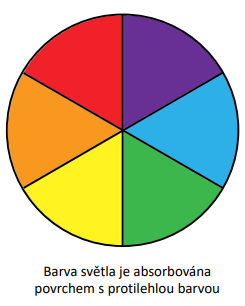

### Vady

Chromatická aberace
- barevné lemování na přechodech
- řešení: clona, větší expoziční čas

Difrakce
- snížení ostrosti obrazu
- najít sweetspot clony (cca 1/3 rozsahu)

Vinětace
- více světla na středu obrazu než na krajích
- řešení: clona

Distorze
- zakřivení obrazu - širokoúhlé objektivy
- kalibrace kamery

### Načtení obrázků

In [4]:
def load_images(path='data/'):
    images = []
    files = os.listdir(path)
    for f in files:
        image = load_image(path + f)
        images.append(image)
        
    plot_images(*images)
    return images

In [5]:
def load_from_file(file="img.bmp"):
    img = load_image(file) # openCV je BGR
    # img_bin = to_gray(img.copy())
    # img_hsv = to_hsv(img.copy())
    # img_rgb = to_rgb(img.copy())
    # img_3 = to_3_channels(img_bin)
    # img_bin = negative(img_bin)
    print(f'Rozměry: {img.shape}')
    plot_images(img)
    return img

In [6]:
def crop_image(img, up_l=(0, 0), bot_r=(-1, -1)):
    img_cropped = crop(img, up_l[0], up_l[1], bot_r[0], bot_r[1]) # Tx, Ty, Bx, By
    print(f'Nové rozměry: {img_cropped.shape}')
    plot_images(img, img_cropped)
    return img_cropped

## Kalibrace kamery

In [7]:
def camera_calibration(img, calib_images_folder_path="calibration", chess_shape=(6,9)):
    images_format='%01d.bmp'
    calibration_file_name="camera_calib.yaml"

    reindex_image_files(calib_images_folder_path) # přejmenování obrázku pro kalibraci pro cv2.VideoCapture
    output_calib_file_path = create_file_path(calib_images_folder_path, calibration_file_name) # cesta k souboru s kalibrací
    input_source = create_file_path(calib_images_folder_path, images_format) # cesta k obrázkům pro kalibraci
    camera_matrix, dist_coeffs, good_images = camera_calib(input_source=input_source, chess_shape=chess_shape, output_calib_file=output_calib_file_path) # kalibrace
    
    img_corrected = correct_frame(img, camera_matrix, dist_coeffs) # spuštění korekce na obrázek
    plot_images(img, img_corrected)
    
    return img_corrected

## Předpracování

### Morfologie

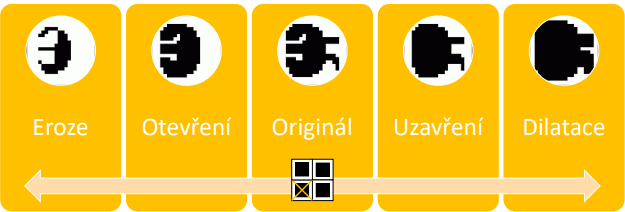

In [8]:
def dilatace(img, k_size):
    return cv2.dilate(img, np.ones((k_size, k_size), np.uint8), iterations = 1)

In [9]:
def eroze(img, k_size):
    return cv2.erode(img, np.ones((k_size, k_size), np.uint8), iterations = 1)

In [10]:
def closing(img, k_size):
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((k_size, k_size), np.uint8))

In [11]:
def opening(img, k_size):
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((k_size, k_size), np.uint8))

Filtrace

In [12]:
def filtrace(img):
    img_filt = filtration_median(img, 5)
    img_filt = filtration_gauss(img, 5, 1) # kernel_size, sigma
    return img_filt

Bitové operace

In [13]:
def cv_bit_operace(img, mask, background, seg):
    img_merged = cv2.bitwise_or(img, negative(background))
    img_merged = cv2.bitwise_and(img, img, mask=mask)
    img_merged = cv2.add(seg, cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask)))
    return img_merged

Kreslení

In [14]:
def draw_circle_line(img, pt, line):
    img_draw = to_3_channels(img)
    cv2.circle(img_draw, pt, 5, (0, 0, 255), -1)
    cv2.line(img_draw, line[0], line[1], (0, 0, 255), 2)    
    return img_draw

Oříznutí masky

In [15]:
def crop_mask(mask):
    mask_cropped = crop_by_bounding_rect(mask)
    return mask_cropped

Vzdálenost bodů

In [16]:
def euklid_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

## Segmentace

In [17]:
def auto_segmentace(img, size=10):
    img = to_gray(img.copy())
    img_seg1 = segmentation_auto_threshold(img)
    img_seg2 = segmentation_adaptive_threshold(img, size)
    plot_images(img_seg1, img_seg2, titles=['auto', 'adaptive'])
    return img_seg1, img_seg2

Černobílý

In [18]:
def interactive_segmentation_binary(img_bin):
    result = None
    @interact(threshold_range=create_slider(min=0, max=255, description='Intensity:',))
    def _(threshold_range):
        mask = segmentation_two_thresholds(img, threshold_range[0], threshold_range[1])
        result = mask
        plot_images(mask, apply_mask(img, mask))

    return result

BGR

In [19]:
def interactive_segmentation_color(img):
    result = None
    @interact(blue=create_slider(min=0, max=255, description='Blue:'),
            green=create_slider(min=0, max=255, description='Green:'),
            red=create_slider(min=0, max=255, description='Red:'))
    def _(blue, green, red):
        mask = segmentation_two_thresholds(img, (blue[0], green[0], red[0]), (blue[1], green[1], red[1])) ###
        result = mask
        plot_images(mask, apply_mask(img, mask))

    return result

HSV

In [20]:
def interactive_segmentation_hsv(img):
    result = None
    @interact(h_range=create_slider(min=0, max=360, description='Hue:'),
            s_range=create_slider(min=0, max=255, description='Saturation:'),
            v_range=create_slider(min=0, max=255, description='Value:'))
    def _(h_range, s_range, v_range):
        lower_bound = (to_intensity(h_range[0]), s_range[0], v_range[0])
        upper_bound = (to_intensity(h_range[1]), s_range[1], v_range[1])
        mask = segmentation_two_thresholds(img_hsv, lower_bound, upper_bound)
        result = mask
        plot_images(mask, apply_mask(img, mask))

    return result

Barevná HSV segmentace

In [21]:
def multicolor_segmentation(img_hsv):
    colors = ['green', 'blue', 'purple', 'yellow', 'orange', 'pink', 'red']
    color_thresholds = {}
    
    # initialize sliders, buttons etc.
    h_slider=create_slider(min=0, max=360, description='Hue:')
    s_slider=create_slider(min=0, max=255, description='Saturation:')
    v_slider=create_slider(min=0, max=255, description='Value:')
    
    color_dropdown = widgets.Dropdown(options=colors, description='Color:'.ljust(30, '\xa0'), style ={'description_width': 'initial'},layout = {'width': 'max-content'})
    
    save_button = widgets.Button(description='Save threshold for color',layout=widgets.Layout(width='auto'),button_style='success')
    finish_button = widgets.Button(description='Return saved thresholds',layout=widgets.Layout(width='auto'),button_style='danger')
    text_output = widgets.Output()

    def find_thresholds(h_range, s_range, v_range):
        lower_bound=(to_intensity(h_range[0]), s_range[0], v_range[0])
        upper_bound=(to_intensity(h_range[1]), s_range[1], v_range[1])
        mask = segmentation_two_thresholds(img_hsv, lower_bound, upper_bound)
        plot_images(mask, apply_mask(img, mask))

    interactive_output = widgets.interactive_output(find_thresholds, {'h_range':h_slider,'s_range':s_slider,'v_range':v_slider})
    
    input_box = widgets.VBox([h_slider,s_slider,v_slider,color_dropdown])
    button_box = widgets.HBox([save_button, finish_button])
    other_box = widgets.VBox([text_output, interactive_output])
    
    def reset_sliders():
        h_slider.value = (0,360)
        s_slider.value = (0,255)
        v_slider.value = (0,255)
    
    def on_save_clicked(b):
        with text_output:
            text_output.clear_output()
            color_thresholds[color_dropdown.value] = (h_slider.value, s_slider.value, v_slider.value)
            print(f"Saved for color '{color_dropdown.value}', threshold: {color_thresholds[color_dropdown.value]}\nResetting sliders...\nChanging to next color...")
            reset_sliders()
            color_dropdown.value = colors[(colors.index(color_dropdown.value)+1)%len(colors)]
        
    def on_finish_clicked(b):
        with text_output:
            text_output.clear_output()
            print('Returned saved thresholds!')
            reset_sliders()
    
    save_button.on_click(on_save_clicked)
    finish_button.on_click(on_finish_clicked)
    display(input_box, button_box,other_box)

    for color, threshold in color_thresholds.items():
        print(f'Barva: {color}, Práh: {color_thresholds[color]}')

## Počítání

- vysegmentovat objekty
- najít vyplněné kontury
- spočítat kontury

## Kontury

In [22]:
def contour_work(mask, min_area=0, max_area=np.inf):
    contour_mask, num_contours, contours = find_contours(mask, min_area, max_area, fill=True, external=True)
    contours_filled = fill_holes(mask, close=True, size=5)
    contours_drawn = to_3_channels(mask)
    cv2.drawContours(contours_drawn, contours, -1, color=(0, 0, 255), thickness=1)

    if num_contours > 0:
        contours.sort(key=cv2.contourArea, reverse=True) # seřazení kontur podle plochy
        contour_biggest = max(contours, key=cv2.contourArea) # zisk největší kontury
        print(f'Plocha největší kontury: {cv2.contourArea(contour_biggest):.0f}') # , souřadnice:\n {contour_biggest.reshape((-1, 2)).tolist()}

    print(f'Nalezeno {num_contours} kontur.')
    plot_images(contours_drawn, contours_filled, contour_mask)
    return contour_mask, contours

### Obdélník kontury

In [23]:
def rect_work(img, contour):
    rect = cv2.minAreaRect(contour) # odhad kontury obdélníkem, fmt: (střed, (výška, šířka), úhel rotace)
    vertices = cv2.boxPoints(rect)

    # nakreslení rohů obdélníka do původního obrázku
    box_points_drawn = to_3_channels(img.copy())
    for p in vertices:
        cv2.circle(box_points_drawn,(int(p[0]),int(p[1])), 3, (0,0,255), -1)
    plot_images(box_points_drawn)
    return vertices

## Měření
- černobílý obrázek
- segmentace objektu
- kontura objektu

Poměr cm/pixel

In [24]:
def real_pixel_ratio(rect, ref_width_real=4, ref_height_real=8): # cm
    ref_width_pixel, ref_height_pixel = rect[1] # pozor na pořadí výšky a šířky!
    return ref_width_real/ref_width_pixel # poměr cm/pixel

Zapsání velikostí kontur do obrázku

In [25]:
def draw_sizes_to_contour(img, contours, real_image_ratio):
    sizes_drawn = img.copy()
    for c in contours:
        rect = cv2.minAreaRect(c)
        shape_width, shape_height = rect[1] # pozor na pořadí výšky a šířky
        real_width = shape_width * real_image_ratio
        real_height = shape_height * real_image_ratio
        print(rect[1], real_width, real_height)
        
        cv2.drawContours(sizes_drawn, [c], -1, color=(0, 0, 255), thickness=5)
        sizes_drawn = draw_real_sizes(
            sizes_drawn,
            rect,
            real_width,
            real_height, 
            lbl_size_scale=.7,
            lbl_color=(0, 0, 255),
            lbl_thickness=1
        )
    plot_images(sizes_drawn)

## Perspektiva

Projekce

In [26]:
def projection(img, src_pts=np.array([(380, 316),(1622,320),(1880,1025),(32,961)]), dst_pts=np.array([(0, 0),(2970, 0),(2970, 2100),(0, 2100)])):
    H, mask = cv2.findHomography(src_pts, dst_pts)
    warped_img = cv2.warpPerspective(img, H, (2970, 2100))
    plot_images(img, warped_img)
    return H, warped_img

Vzdálenost bodů v rovině projekce

In [27]:
def calculate_projection_distance(H, line_start=np.array([[(479, 705)]], dtype='float32'), line_end=np.array([[(1330, 584)]], dtype='float32')):
    line_start_t = cv2.perspectiveTransform(line_start, H)
    line_end_t = cv2.perspectiveTransform(line_end, H)
    dist = np.linalg.norm(line_start_t - line_end_t)
    return dist

Referenční vzdálenosti a měřené vzdálenosti

In [28]:
# úsečky musejí začínat ve stejné rovině a být vertikální
# Struktura: TOP; BTM; reálná vzdálenost
REFERENCE_MEASUREMENTS = [
    ((148, 214), (110, 980), 12),
    ((922, 22), (898, 1008), 15),
    ((1516, 216), (1524, 1014), 12),
]

# Dvojice měřených bodů objektů z obrazu
Tx = ((532, 106), (1026, 564))
Bx = ((510, 1136), (1022, 1068))

Úběžníky

In [29]:
def ubezniky(img):
    img_rgb = to_rgb(img.copy())
    vps = compute_vanishing_points(img_rgb)
    vl = np.cross(vps[0], vps[1]) # horizontální úběžníky
    vpz = vps[2] # osa z
    return vl, vpz

Výpočet výšky objektů

In [30]:
def get_height(REFERENCE_MEASUREMENTS, vl, vpz):
    height_estimator = improutils.HeightEstimator(REFERENCE_MEASUREMENTS, vl, vpz)
    return abs(height_estimator.calc_height(Tx[1], Bx[1])) # height

## Fourierova transformace

Odstranění opakujícího se vzoru

In [31]:
def FFT(cardboard_normalized):
    mag_spec, spectrum_shift = apply_fft(cardboard_normalized)

    filter_mask_final = negative(create_filter_mask(cardboard_normalized.shape, [], [249,250]))

    spec_mask_filt_final = filter_mag_spec(mag_spec, filter_mask_final)
    cardboard_filt_final = inverse_fft(spectrum_shift, filter_mask_final).astype(np.uint8)

    plot_images(filter_mask_final, spec_mask_filt_final, cardboard_filt_final, normalize=True)

## OCR

In [32]:
def find_holes(img_bin,min_area = 0, max_area=1000000, fill = True):
    contours, hierarchy = cv2.findContours(img_bin,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    hole_indices = [ i for i in range(len(hierarchy[0])) if hierarchy[0,i,-1] != -1]    
    contours = [contours[hole_index] for hole_index in hole_indices if min_area < cv2.contourArea(contours[hole_index]) <= max_area]
    thick = cv2.FILLED
    if not fill: thick = 2
    contours_drawn = cv2.drawContours(np.zeros(img_bin.shape, dtype=np.uint8), contours, -1, color=(255, 255, 255),thickness=thick)
    return contours_drawn, len(contours), contours

def ocr(img_bin):
    config = r' -l eng --psm 6'
    img_bin = negative(img_bin)
    return pytesseract.image_to_string(img_bin, config=config)

In [33]:
def ocr_work(img):
    filtered = filtration_median(img, 5)
    segmented = segmentation_adaptive_threshold(filtered, 10)
    mask, _, _ = find_holes(segmented, 100)
    return ocr(mask)